<a id="topE"></a>

# Editing the extraction boxes in a spectral extraction file (XTRACTAB)

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Altering the extraction box used to extract your spectrum from a COS `TIME-TAG` exposure file.**
   #### 1. [**Investigating the exposure**](#invE)
   ##### - 1.1. [Understanding the XTRACTAB and getting the first glimpse of a 2D spectrum](#lookE)
   ##### - 1.2. [Defining some useful functions](#funE)
   ##### - 1.3. [Examining the extraction boxes](#boxE)

#### 2. [**Editing the extraction boxes**](#editE)
   ##### - 2.1. [Defining an editing function](#edfnE)
   ##### - 2.2. [Make the edits](#mkedE)
   ##### - 2.3. [Confirming the changes](#confE)
  
#### 3. [**Running the CalCOS Pipeline with the new XTRACTAB**](#calexE)
   ##### - 3.1. [Edit the XTRACTAB header value](#edhdrE)
   ##### - 3.2. [Run the pipeline](#runcE)

#### 4. [**Example using FUV Data**](#fuvE)


# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through altering the extraction box sizes in the XTRACTAB/`_1dx` file to make sure you are extracting the cleanest possible signal from your source and background. We will demonstrate this in both the NUV and FUV. 
*Note* that some COS modes which use the FUV detector can be better extracted using the [TWOZONE method](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-2-pipeline-processing-overview), which is not directly discussed in this notebook. All COS/NUV modes use the [BOXCAR method](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-2-pipeline-processing-overview#id-3.2PipelineProcessingOverview-3.2.1OverviewofTWOZONEextraction) discussed in this notebook.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `numpy` to handle arrays and functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `glob`, `os`, and `shutil` for working with system files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `matplotlib.pyplot` for plotting
- `matplotlib.image` for reading in images
- `calcos` to run the CalCOS pipeline for COS data reduction
- `scipy.interpolate interp1d` for interpolating datasets to the same sampling

These python packages are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

We'll also filter out two unhelpful warnings about a deprecation and dividing by zero which do not affect our data processing.

In [ ]:
# for array manipulation
import numpy as np
# for reading fits files
from astropy.table import Table
from astropy.io import fits
# For downloading the data
from astroquery.mast import Observations as Obs
# Plotting
from matplotlib import pyplot as plt
# For showing images from within Python
from matplotlib import image as mpimg
# For dealing with system files
import glob, os, shutil
# For running the CalCOS pipeline
import calcos
# For comparing the old and new CalCOS values
from scipy.interpolate import interp1d 

# We will also suppress a warning that won't affect our data processing:
np.seterr(divide = 'ignore') 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## We will also define a few directories we will need:

In [ ]:
# These will be important directories for the notebook
datadir = './data/'
outputdir = './output/'
plotsdir = './output/plots/'

# Make the directories in case they don't exist
!mkdir ./output
!mkdir ./output/plots
!mkdir ./data

## And we will need to download the data we wish to work with:
We choose the exposures with the association obs_id: `LE4B04010` and download all the `_rawtag` data. This dataset happens to be COS/NUV data taken with the G185M grating, observing the star: [LS IV -13 30](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=%402582869&Name=LS%20%20IV%20-13%20%20%2030&submit=submit).
For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).
##### *Note*, we're working with the `_rawtags` because they are smaller files and quicker to download than the `_corrtag` files. However, this workflow translates very well to using `_corrtag` files, as you likely will want to do when working with your actual data. If you wish to use the default corrections converting from raw to corrected `TIME-TAG` data, you may instead download and work with `CORRTAG` files directly.

In [ ]:
pl = Obs.get_product_list(Obs.query_criteria(obs_id='LE4B04010'))
masked_pl = pl[np.isin(pl['productSubGroupDescription'],['RAWTAG', 'ASN', 'X1DSUM'])] # You could put 'CORRTAG' here
# Now download:
Obs.download_products(masked_pl)

We gather a list of all the `_rawtag` files we have downloaded, as well as the `_asnfile` and `_x1dsum` file:

In [ ]:
rawtags = glob.glob('./mastDownload/HST/**/*_rawtag.fits', 
                    recursive=True)
asnfile = glob.glob('./mastDownload/HST/**/*_asn.fits', 
                    recursive=True)[0]
old_x1dsum = glob.glob('./mastDownload/HST/**/*_x1dsum.fits', 
                    recursive=True)[0]

<a id = invE></a>
# 1. Investigating the exposure

<a id = lookE></a>
## 1.1. Understanding the XTRACTAB and getting the first glimpse of a 2D spectrum
The raw data from the COS instrument is a series of events, each corresponding to a photon interacting with the detector at a specific X, Y point, (*and at a specific time if in `TIME-TAG` mode*). We generally wish to translate this to a 1-dimensional spectrum (*Flux or Intensity on the y axis vs. Wavelength on the x axis*). To do this, we can plot all the X,Y points of the spectrum onto a 2D image of the detector. The different spectra (i.e. of the NUV of FUV target, the wavelength calibration source) then appear of stripes of high count density on this image. We can then simply draw extraction boxes around these stripes, and integrate to collapse the data onto the wavelenth axis.

### The XTRACTAB is a fits file which contains a series of parallelogram "boxes" to be used for different COS modes.
These are the boxes which we collapse to create a 1-dimensional spectrum. For each combination of COS lifetime position, grating, cenwave, etc., the extraction box is specified by giving the slope and y-intercept of a line, and the height of the parallelogram which should be centered on the line. Similar boxes are specified for background regions. For more information on the XTRACTAB, see the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-7-reference-files#id-3.7ReferenceFiles-3.7.12XTRACTAB:1-DSpectralExtractionTablehttps://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-7-reference-files#id-3.7ReferenceFiles-3.7.12XTRACTAB:1-DSpectralExtractionTable).

### For many reasons, we may wish to use an extraction box different from the one specified by the default XTRACTAB, and instead set the boxes manually.
We then need to see where the NUV stripes fall in order to determine where we should place the extraction boxes. First, let's plot this as a 2D image of the raw counts.
To begin, we grab and plot the raw counts data from the 0th rawtag file:

In [ ]:
# Get the data from the first rawtag
rawtag = rawtags[0]
rtd = Table.read(rawtag,1)
###

plt.figure(figsize=(10,8))
# Plot the raw counts:
plt.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')

# plot Lines roughly centered on the 3 NUV stripes:
for i, (line,label) in enumerate(zip([187,285,422],['NUVA', 'NUVB', 'NUVC'])): 
    plt.axhline(line, color = 'myr'[i], linewidth = 3, alpha = 0.8, linestyle = 'dotted', label = label)

plt.xlim(0,1024)
plt.ylim(0,1024)

plt.xlabel('Dispersion axis Pixel', size = 20)
plt.ylabel('Cross-dispersion axis Pixel', size = 20)
plt.title("Fig 1.1\n2D spectrum of all raw (unfiltered) counts", size = 25)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

#### The dense stripes in the lower half of Fig 1.1 (*highlighted by the dotted lines*) are the actual science data raw counts, while the patchy stripes towards the top are the wavelength calibration counts.

### Now we'll need to see where the original `XTRACTAB` places its extraction boxes:
Find the name of the `XTRACTAB` used by this first `_rawtag` file:

In [ ]:
orig_xtractab = fits.getheader(rawtag)['XTRACTAB']

### If you have an existing `lref` directory with a cache of reference files:
Give the system the `lref` system variable, which points to the reference file directory, uncomment the cell below (beginning with "`#### YES lref?`"), and comment out the following code cell (beginning with "`#### NO lref?`")

In [ ]:
#### YES lref?

# lref = '/path/to/your/lref/'
# %env lref /path/to/your/lref/
# orig_xtractab = lref + orig_xtractab.split('$')[1] # This is the full path

### If you don't have an existing `lref` directory with a cache of reference files:

If you do not have a local copy of the reference files, (i.e. an lref directory,) you may, for the purposes of this notebook, download just the `XTRACTAB` using the cell below:

In [ ]:
#### NO lref?

%env CRDS_PATH ./data
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env lref ./data/references/hst/cos/
lref = './data/references/hst/cos/'
! crds sync --files=w5g1439sl_1dx.fits

orig_xtractab = lref + orig_xtractab.split('$')[1] # This is the full path


<a id = funE></a>
## 1.2. Defining some useful functions

We'll define a few functions to:
- Read in the data rows containing relevant extraction boxes from an XTRACTAB file
- Plot these extraction boxes over a spectrum 
  + *for clarity and signal to noise, we'll collapse this spectrum onto the y (cross-dispersion) axis*

### First, we'll write a function to read in the relavent extraction boxes from an XTRACTAB:

In [ ]:
def readxtractab(xtractab, grat, cw, aper):

    """
    Reads in an XTRACTAB row of a particular COS mode and\
    gets extraction box sizes and locations.
    Inputs:
    xtractab (str) : path to xtractab file.
    raw (bool) : default False, meaning that the data is assumed to be corrtag.
    grat (string) : grating of relavent row (i.e. "G185M")
    cw (int or numerical) : cenwave of relavent row (i.e. (1786))
    aper (str) : aperture of relavent row (i.e. "PSA")
    Returns:
    y locations of bottoms/tops of extraction boxes
        if NUV: stripe NUVA/B/C, and 2 background boxes
        elif FUV: FUVA/B, and 2 background boxes for each FUVA/B.
    """
    with fits.open(xtractab) as f:
        xtrdata = f[1].data # Get the fits data
    
    isFUV = fits.getheader(xtractab)['DETECTOR'] == 'FUV'
    
    if not isFUV: # Then NUV data:
        sel_nuva = np.where((xtrdata['segment'] == 'NUVA') & # Find NUVA 
                            (xtrdata['aperture'] == aper) & # of the right row
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') & # Now NUVB
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') & # Now NUVC
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        hgta = xtrdata['HEIGHT'][sel_nuva][0] # get heights
        hgtb = xtrdata['HEIGHT'][sel_nuvb][0] #  of spec extract boxes
        hgtc = xtrdata['HEIGHT'][sel_nuvc][0]

        bspeca = xtrdata['B_SPEC'][sel_nuva][0] # y-intercept (b) of spec 
        bspecb = xtrdata['B_SPEC'][sel_nuvb][0] #  boxes
        bspecc = xtrdata['B_SPEC'][sel_nuvc][0]

        boundsa = [bspeca - hgta/2, bspeca + hgta/2] # determine y bounds of boxes 
        boundsb = [bspecb - hgtb/2, bspecb + hgtb/2]
        boundsc = [bspecc - hgtc/2, bspecc + hgtc/2]

        bkg1a = xtrdata['B_BKG1'][sel_nuva] # Do the same for the bkg extract boxes
        bkg2a = xtrdata['B_BKG2'][sel_nuva]
        bhgta = xtrdata['BHEIGHT'][sel_nuva]
        bkg1boundsa = [bkg1a - bhgta/2, bkg1a + bhgta/2]
        bkg2boundsa = [bkg2a - bhgta/2, bkg2a + bhgta/2]

        # the background locations are by default the same for all stripes

        return boundsa, boundsb, boundsc, bkg1boundsa, bkg2boundsa
    
    elif isFUV: # Then FUV data:
        sel_fuva = np.where((xtrdata['segment'] == 'FUVA') & # Find NUVA 
                            (xtrdata['aperture'] == aper) & # of the right row
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        sel_fuvb = np.where((xtrdata['segment'] == 'FUVB') & # Now NUVB
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))
        hgta = xtrdata['HEIGHT'][sel_fuva][0] # get heights
        hgtb = xtrdata['HEIGHT'][sel_fuvb][0] #  of spec extract boxes
        bspeca = xtrdata['B_SPEC'][sel_fuva][0] # y-intercept (b) of spec 
        bspecb = xtrdata['B_SPEC'][sel_fuvb][0] #  boxes
        boundsa = [bspeca - hgta/2, bspeca + hgta/2] # determine y bounds of boxes 
        boundsb = [bspecb - hgtb/2, bspecb + hgtb/2]

        bkg1a = xtrdata['B_BKG1'][sel_fuva] # Do the same for the bkg extract boxes
        bkg2a = xtrdata['B_BKG2'][sel_fuva]
        bhgt1a = xtrdata['B_HGT1'][sel_fuva]
        bhgt2a = xtrdata['B_HGT2'][sel_fuva]
        bkg1boundsa = [bkg1a - bhgt1a/2, bkg1a + bhgt1a/2]
        bkg2boundsa = [bkg2a - bhgt2a/2, bkg2a + bhgt2a/2]
        
        bkg1b = xtrdata['B_BKG1'][sel_fuvb] # Do the same for the bkg extract boxes
        bkg2b = xtrdata['B_BKG2'][sel_fuvb]
        bhgt1b = xtrdata['B_HGT1'][sel_fuvb]
        bhgt2b = xtrdata['B_HGT2'][sel_fuvb]
        bkg1boundsb = [bkg1b - bhgt1b/2, bkg1b + bhgt1b/2]
        bkg2boundsb = [bkg2b - bhgt2b/2, bkg2b + bhgt2b/2]

        return boundsa, boundsb, bkg1boundsa, bkg2boundsa, bkg1boundsb, bkg2boundsb
# We'll note the returned values correspond to these extraction boxes
box_names = ['NUVA','NUVB','NUVC','BKG-1','BKG-2']
box_names_fuv = ['FUVA','FUVB','BKG-1A','BKG-2A','BKG-1B','BKG-2B']

### We'll now need two functions in order to plot
The first function (`makeims()`) is a helper function for the second: `collapsey()`.

`collapsey()` takes a list of either `_rawtag` or `_corrtag` exposure files, as well as an `XTRACTAB` file, and creates a summary plot, with the 2D spectrum collapsed onto the y-axis.

In [ ]:
def makeims(xarr, yarr):
    """
    Helper function for collapsey(): converts counts to image.
    """
    new_img = np.zeros((1024, 1024))
    xbin = np.asarray(np.floor((xarr + 0.5)), dtype=np.int)
    ybin = np.asarray(np.floor((yarr + 0.5)), dtype=np.int)
    # Add a count for each x,y pair
    for x, y in zip(xbin, ybin):
        try:
            new_img[y, x] += 1
        except IndexError:
            continue
    return new_img

### Collapse in y axis function

In [ ]:
def collapsey(tagfiles, xtractab, raw = False, save = True, savename = False, display = True, fignum = False): # assumes corrtag, but will work with rawtag if raw=True
    """
    Takes a corrtag (default) or rawtag and makes a plot of the 2D spectrum collapsed to the y axis\
    i.e. summed over rows of pixels in the dispersion direction\
    then it overplots the extraction regions from a provided xtractab.
    The behavior is the same for CORRTAG/RAWTAG, only the data columns differ.
    
    Inputs:
    tagfiles (list of str) : list of rawtag or corrtag file paths.
    xtractab (str) : path to xtractab.
    raw (bool) : default False, meaning that the data is assumed to be corrtag.
    save (bool) : Do you want to save the image of the plot? Default True
    savename (str if specified) : name to save file as in plotsdir, if save == True.
    display (bool) : Display the image? Default True.
    fignum  (str if specified) : Figure number to include in figtitle. Dafault is False.
    
    Outputs:
    yprof (numpy array of floats) : the 2D spectrum collapsed onto the y axis.
    """
    plt.figure(figsize=(12, 8))

    for numfile, myfile in enumerate(tagfiles): # go through all the tag files

        with fits.open(myfile) as f: # Grab data from file
            data = f[1].data
            h0 = f[0].header

        fppos = h0['FPPOS'] # get important header keys to determin row
        rootname = h0['ROOTNAME']
        target = h0['TARGNAME']
        grating = h0['OPT_ELEM']
        cenwave = h0['CENWAVE']
        
        if not raw: # grab corrected or raw time-tag points x and y locations
            xcorr = data['XCORR']
            ycorr = data['YCORR']

        elif raw:
            rawx = data['RAWX']
            rawy = data['RAWY']
            
        if raw: # call helper function on time tag data
            nuvim = makeims(rawx, rawy)
        else:
            nuvim = makeims(xcorr, ycorr)

        yprof = np.sum(nuvim, axis=1) # collapse onto the y axis

        # Make the main y-axis spectrum plot
        yaxis = np.arange(0, 1024)
        plt.plot(yprof, yaxis, label=f'{rootname} fppos = {fppos}')
        if numfile == 0: # Add in the plot formatting (just once - on the 0th file)
            if raw:
                plt.ylabel('RAWY Pixel', size = 18)
            else:
                plt.ylabel('YCORR Pixel', size = 18)

            plt.xlabel('Counts summed along X', size = 18)
            fig_title = f"Target: {target} spectrum;" +"\n"+f"XTRACTAB: {os.path.basename(xtractab)}"
            if fignum:
                fig_title = f"Fig {fignum}" + "\n" + fig_title
            plt.title(fig_title, fontsize = 23)
            psaboundsa, psaboundsb, psaboundsc, psabkg1, psabkg2 = readxtractab(xtractab, grating, cenwave, 'PSA')
            wcaboundsa, wcaboundsb, wcaboundsc, wcabkg1, wcabkg2 = readxtractab(xtractab, grating, cenwave, 'WCA')

            span = plt.axhspan(psaboundsa[0], psaboundsa[1], color='lightgray', label = 'PSA regions', alpha=0.7)
            plt.axhspan(psaboundsb[0], psaboundsb[1], color='lightgray', alpha=0.7)
            plt.axhspan(psaboundsc[0], psaboundsc[1], color='lightgray', alpha=0.7)

            span = plt.axhspan(psabkg1[0], psabkg1[1], color='lightblue', label = 'Background regions' , alpha=0.7)
            plt.axhspan(psabkg2[0], psabkg2[1], color='lightblue', alpha=0.7)
            span = plt.axhspan(wcaboundsa[0], wcaboundsa[1], color='lightgreen', label = 'WCA regions', alpha=0.7)
            plt.axhspan(wcaboundsb[0], wcaboundsb[1], color='lightgreen', alpha=0.7)
            plt.axhspan(wcaboundsc[0], wcaboundsc[1], color='lightgreen', alpha=0.7)
    
    plt.legend(loc = 'upper right')
    
    plt.tight_layout()
    
    ### Saving the figure:
    if save: # Do we want to save the image at all?
        if not savename: # Save in the default manner
            plt.savefig(plotsdir+f"{target}_regions.png", dpi = 200, bbox_inches = 'tight')
        elif savename: # Save with input savename
            plt.savefig(plotsdir+f"{savename}.png", dpi = 200, bbox_inches = 'tight')
    if display:
        plt.show()
    plt.close()
    plt.clf()
    
    return yprof

<a id = boxE></a>
## 1.3. Examining the extraction boxes
### Now let's make a plot showing where these original `XTRACTAB` boxes fall on the raw count image:

### It's important to note that each extraction box also has a slope associated with it. This slope is generally very small, and we will not plot the boxes with their slopes while determining the box centers and heights. However, for the purposes of actual extractions, these slopes should be incorporated to determine final extraction bounds.

In [ ]:
read_bounds = readxtractab(orig_xtractab, # bounds of all boxes...
                           grat='G185M', cw=1786, aper='PSA') # ...for these conditions

plt.figure(figsize=(10,8)) # Set up figure

plt.scatter(rtd['RAWX'],rtd['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0')

for i, (box, bname) in enumerate(zip(read_bounds, box_names)): # add all the boxes
    plt.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , label = bname)

plt.legend(loc = 'upper right') # Add plot formatting
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.xlabel('Dispersion axis Pixel', size = 20)
plt.ylabel('Cross-dispersion axis Pixel', size = 20)
plt.suptitle("Fig 1.2\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original extraction boxes", size = 25)
plt.tight_layout()
plt.savefig(plotsdir+'/2D_spec_orig_boxes.png', dpi = 200, bbox_inches = 'tight')

In [ ]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles = rawtags, xtractab = orig_xtractab, raw = True,
                      save = True, savename = "orig_xtractab_col_y", fignum = "1.3")

<a id = editE></a>
# 2. Editing the extraction boxes

#### Now that we know how to show the location of the extraction boxes, we can get to the actual editing. We'll define another function to edit the existing XTRACTAB and save to a new file:

<a id = edfnE></a>
## 2.1. Defining an editing function

In [ ]:
def edit_xtractab(xtractab, gratlist, cwlist, h_dict, b_dict, new_filename):

    """
    Function to actually edit the XTRACTAB itself\
    Change the height and y-intercepts of the extraction boxes,\
    and save to new XTRACTAB (1dx) file.
    Inputs:
    xtractab (str) : path to the XTRACTAB to edit
    gratlist (list of str) : all the gratings whose rows you would like to edit
    cwlist (list of str) : all the cenwave whose rows you would like to edit
    h_dict (dict of numerical) : heights of NUV A,B,C extraction boxes. Should be ODD!
    b_dict (dict) : dict of the y-intercepts - i.e. box center locations
    new_filename : filename/local path to new XTRACTAB file to create
    """
    
    f = fits.open(xtractab)

    xtrdata = f[1].data
    isFUV = fits.getheader(xtractab)['DETECTOR'] == 'FUV'
    
    for height in h_dict: # Print warning if even height is specified
        if h_dict[height] % 2 == 0:
            print("WARNING " + f"Height of {height} is currently even ({h_dict[height]}), but " +
                  "should be ODD. Allowed change, but unadvised.")
    
    for grat in gratlist:

        for cw in cwlist:
            if not isFUV: # Then NUV data:

                sel_nuva = np.where((xtrdata['segment'] == 'NUVA') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                # change the background region locations:

                xtrdata['B_BKG1'][sel_nuva] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuva] = b_dict['bbkg2']

                xtrdata['B_BKG1'][sel_nuvb] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuvb] = b_dict['bbkg2']

                xtrdata['B_BKG1'][sel_nuvc] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuvc] = b_dict['bbkg2']

                # change the extraction heights
                
                xtrdata['HEIGHT'][sel_nuva] = h_dict['h_a']
                xtrdata['HEIGHT'][sel_nuvb] = h_dict['h_b']
                xtrdata['HEIGHT'][sel_nuvc] = h_dict['h_c']

                # change the B_SPEC

                xtrdata['B_SPEC'][sel_nuva] = b_dict['bspa']
                xtrdata['B_SPEC'][sel_nuvb] = b_dict['bspb']
                xtrdata['B_SPEC'][sel_nuvc] = b_dict['bspc']
                
                
            elif isFUV: # Then FUV data:
                sel_fuva = np.where((xtrdata['segment'] == 'FUVA') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_fuvb = np.where((xtrdata['segment'] == 'FUVB') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))
                # change the background region locations:
                xtrdata['B_BKG1'][sel_fuva] = b_dict['bbkg1a']
                xtrdata['B_BKG2'][sel_fuva] = b_dict['bbkg2a']
                #
                xtrdata['B_BKG1'][sel_fuvb] = b_dict['bbkg1b']
                xtrdata['B_BKG2'][sel_fuvb] = b_dict['bbkg2b']
                # change the extraction heights
                xtrdata['HEIGHT'][sel_fuva] = h_dict['h_a']
                xtrdata['HEIGHT'][sel_fuvb] = h_dict['h_b']
                # change the B_SPEC
                xtrdata['B_SPEC'][sel_fuva] = b_dict['bspa']
                xtrdata['B_SPEC'][sel_fuvb] = b_dict['bspb']
                
    # save and close the file

    f.writeto(new_filename, overwrite=True)

    f.close()

    return

<a id = mkedE></a>
## 2.2. Make the edits

### Now we'll need to actually edit the XTRACTAB file to have different sizes and locations of the extraction boxes using `edit_xtractab()`.

For the purposes of this example, we'll **arbitrarily** set our y-intercepts and heights, just trying to roughly cover the NUV stripes, and show the different heights we can set the boxes to. *Note* that this function does not stop us from setting the boxes to overlap - but, dependent on your data, this may be a bad idea. 

The scope of this notebook is merely to explain *how* to alter the extraction boxes, not to determine the best box locations for any given dataset. While we cannot give specific rules to fit every single dataset, the general rules suggest you: 
* define spectral extraction boxes which contain as much flux from the target as possible while including very little of the background region
* define background extraction boxes as close to your target as possible without the possibility of overlap
* avoid detector hotspots and regions of poor sensitivity.
* box heights should be odd, so that there is a central pixel.

#### First we'll set up the values to which we'll edit the box parameters, and then run the function on the original XTRACTAB to change our G185M extraction boxes in the rows for cenwaves 1786 and 1817:

In [ ]:
# These will be the values we set the box params to - fairly arbitrarily chosen values in this case:
intercept_dict = {"bbkg1":900., "bbkg2":60., # centers of the background extract regions
                  'bspa':195., 'bspb':285., 'bspc':415.} # centers of NUV stripe extract regions
hgt_dict = {'h_a':41, 'h_b':51, 'h_c':61}

#Now edit using the edit_xtractab() function
                                    # change G185M grating for cenwaves 1786, 1817:
edit_xtractab(xtractab=orig_xtractab, gratlist = ['G185M'], cwlist = [1786,1817], # data and rows to edit
              h_dict = hgt_dict, # new (arbitrary) heights to set boxes to
              b_dict=intercept_dict, new_filename = './edit_1dx.fits') # new (somewhat arbitrary) y-intercepts (y axis locations) for boxes

<a id = confE></a>
## 2.3. Confirming the changes

### Now let's plot the old and new extraction boxes side-by-side to compare:

In [ ]:
# Set up the plot
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,8), sharey=True)
# add raw count images
ax0.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')
ax1.scatter(rtd['RAWX'],rtd['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')

# First deal with the original XTRACTAB 
read_bounds = readxtractab(orig_xtractab, grat='G185M', cw=1786, aper='PSA')
for i, box in enumerate(read_bounds): #plot each box
    ax0.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , label = box_names[i]+'_new')
# Now with the newly edited XTRACTAB
plt.rcParams['hatch.linewidth'] = 3 # Make the hatch more visible
read_bounds = readxtractab('./edit_1dx.fits', grat='G185M', cw=1786, aper='PSA')
for i, box in enumerate(read_bounds):
    ax1.axhspan(box[0],box[1], color = 'cmykr'[i], alpha = 0.3 , hatch = 'x', label = box_names[i]+'_old')

    # Now some plot formatting
ax0.legend(loc = 'upper right')
ax1.legend(loc = 'upper right')

ax0.set_xlim(0,1024)
ax0.set_ylim(0,1024)
ax1.set_xlim(ax0.get_xlim())

fig.text(0.42,-.01,'Dispersion axis Pixel', size = 20)
ax0.set_ylabel('Cross-dispersion axis Pixel', size = 20)
plt.suptitle("Fig 2.1\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original ($left$) and new ($right$) extraction boxes", size = 25)
plt.tight_layout()
plt.savefig(plotsdir + '2D_spec_both_box_sets.png', dpi = 200, bbox_inches = 'tight')

### We'll also make a plot of the new boxes over the spectrum collapsed onto the y-axis, and we'll plot it side-by-side with Fig 1.3, which shows the original extraction boxes:

In [ ]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles = rawtags, xtractab = './edit_1dx.fits', raw = True,
                      save = True, display = False, savename = "edit_xtractab_col_y", fignum = "2.2")
# Now plot both together
fig, (ax0,ax1) = plt.subplots(1,2,figsize =(25,18))
ax0.imshow(mpimg.imread('./output/plots/orig_xtractab_col_y.png'))
ax1.imshow(mpimg.imread('./output/plots/edit_xtractab_col_y.png'))
ax0.axis('off')
ax1.axis('off')
plt.tight_layout()
plt.show()

<a id = calexE></a>
# 3. Running the CalCOS Pipeline with the new XTRACTAB

<a id = edhdrE></a>
## 3.1. Edit the XTRACTAB header value
More detailed information on changing header parameters can be found in our [walkthrough notebook on `CalCOS`](https://github.com/spacetelescope/COS-Notebooks/blob/master/CalCOS/CalCOS.ipynb).

Here, we just need to tell the pipeline to use our newly edited XTRACTAB. We do this by editing one of the header key values in all of the affected files.

In [ ]:
try: 
    for rawtag in rawtags:
        os.rename(rawtag, datadir + os.path.basename(rawtag))
except FileNotFoundError:
    print ('No files')
try: 
    os.rename(asnfile, datadir + os.path.basename(asnfile))
except FileNotFoundError:
    print ('No files')
rawtags = glob.glob(datadir + '*rawtag*')
asnfile = glob.glob(datadir + '*asn*')[0]

In [ ]:
for rawtag in rawtags:
    print("changing XTRACTAB for ", os.path.basename(rawtag))
    print("\tOriginally: ", fits.getheader(rawtag)['XTRACTAB'])
    fits.setval(filename=rawtag, keyword='XTRACTAB', value= './edit_1dx.fits' )
    print("\tNow set to: ", fits.getheader(rawtag)['XTRACTAB'])

<a id = runcE></a>
## 3.2. Run the pipeline
We will also largely gloss over the details of running the pipeline, `CalCOS`, in this notebook. Once again, much more detailed information on running the `CalCOS` pipeline can be found in our [walkthrough notebook on `CalCOS`](https://github.com/spacetelescope/COS-Notebooks/blob/master/CalCOS/CalCOS.ipynb).

If you don't have an `lref` directory with all your COS reference files, the following cells will fail to run and you should see our tutorial on [Setting up an environment to work with COS data](https://spacetelescope.github.io/COS-Notebooks/Setup.html).

In [ ]:
# set up environment var to find all other ref files
%env lref /grp/hst/cdbs/lref/

In [ ]:
%%capture cap --no-stderr 
# Above, capture the output and save it in the next cell

# This line actually runs the pipeline:
calcos.calcos(asnfile, verbosity = 1, outdir = outputdir+"calcos_run1")

In [ ]:
with open(outputdir+'output_calcos_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

### We'll finish up by plotting the new and original `x1dsum` spectra as extracted with the new and original extraction boxes:
*Note* that we can ignore the UnitsWarning.

In [ ]:
# Set up figure
fig = plt.figure(figsize = (20, 7))
gs = fig.add_gridspec(nrows = 5, ncols = 3) # Using gridspec to let us control panel sizes and locations

for i in range(3):
    ax0 = fig.add_subplot(gs[0:4,i])
    ax1 = fig.add_subplot(gs[4:5,i])
    new_wvln, new_flux = Table.read('./output/calcos_run1/le4b04010_x1dsum.fits')[i]['WAVELENGTH', 'FLUX']
    old_wvln, old_flux, seg = Table.read(old_x1dsum)[i]['WAVELENGTH', 'FLUX', 'SEGMENT']
    
    # Interpolate the new wvln onto the old wvln's sampling:
    new_flux_interp = interp1d(x = new_wvln, y = new_flux, fill_value="extrapolate")(old_wvln)

    # give max difference:
    print(f"Stripe {seg} differs by up to: \
    {max(new_flux - old_flux)/np.mean(abs(old_flux)):.3f}%")

    # Plotting - upper panel
    ax0.plot(new_wvln,new_flux, linewidth = .5, label = '$New$ extracted spectrum')
    ax0.plot(old_wvln,old_flux, linewidth = .5, label = '$Original$ extracted spectrum')
    # Plotting - lower panel
    ax1.plot(new_wvln,old_flux - new_flux_interp, linewidth = .5, label = 'Residual')
    # Some formatting:
    ax0.set_title(f"Segment {seg}", fontsize = 20)
    ax0.set_xticks([])
    ax0.legend(loc = 'lower center')
    ax1.legend(loc = 'lower center')
    if i == 0: # Add axis labels to the plot
        ax0.set_ylabel("Flux\n[$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", fontsize = 20)
    if i == 1:
        plt.xlabel("Wavelength", fontsize = 20)
plt.suptitle("Fig 3.1\nComparing the old and new extracted spectra for each segment", fontsize = 25)
plt.tight_layout()
plt.savefig(plotsdir+"comp_extracted.png", dpi = 200)

<a id = fuvE></a>
# 4. Example using FUV data

### Let's go through doing all of the above with an FUV dataset and corresponding FUV XTRACTAB.

### First download the FUV data, we'll grab an FUV/G160M/C1533 dataset from the same proposal as the NUV dataset.

In [ ]:
pl = Obs.get_product_list(Obs.query_criteria(proposal_id=15869, obs_id = 'LE4B01040'))
masked_pl = pl[np.isin(pl['productSubGroupDescription'],['RAWTAG_A','RAWTAG_B', 'ASN', 'X1DSUM'])]

# Now download:
Obs.download_products(masked_pl)

#### We gather a list of all the `_rawtag` files we have downloaded, as well as the `_asnfile` and `_x1dsum` file:

In [ ]:
rawtags_a = glob.glob('./mastDownload/HST/le4b01*/**/*_rawtag_a.fits', 
                    recursive=True)
rawtags_b = glob.glob('./mastDownload/HST/le4b01*/**/*_rawtag_b.fits', 
                    recursive=True)
rawtags_ab = rawtags_a + rawtags_b
asnfile = glob.glob('./mastDownload/HST/le4b01040/**/*_asn.fits', 
                    recursive=True)[0]
old_x1dsum = glob.glob('./mastDownload/HST/le4b01040/**/*_x1dsum.fits', 
                    recursive=True)[0]

#### Move the files and index them again:

In [ ]:
!mkdir -p ./fuv_data

fdatadir = './fuv_data/' # Move all this FUV data, except the calibrated x1dsum, which we don't need to
[os.rename(rta, fdatadir+ os.path.basename(rta)) for rta in rawtags_a]
[os.rename(rtb, fdatadir+ os.path.basename(rtb)) for rtb in rawtags_b]
os.rename(asnfile, fdatadir+ os.path.basename(asnfile))

# re-find all the data now that it's moved
rawtags_a = glob.glob('./fuv_data/*_rawtag_a.fits', 
                    recursive=True)
rawtags_b = glob.glob('./fuv_data/*_rawtag_b.fits', 
                    recursive=True)
rawtags_ab = rawtags_a + rawtags_b
asnfile = glob.glob('./fuv_data/*_asn.fits', 
                    recursive=True)[0]

### We need to see where the FUV spectra fall in order to determine where we should place the extraction boxes.
#### We'll first plot this as a 2D image of the raw counts.
We grab and plot the raw counts data from the 0th `rawtag_a` and `rawtag_b` files:

In [ ]:
# Get the data from the first rawtag
rtda = Table.read(rawtags_a[0],1)
rtdb = Table.read(rawtags_b[0],1)
###

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8))
ax0.scatter(rtdb['RAWX'],rtdb['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')
ax1.scatter(rtda['RAWX'],rtda['RAWY'], s= 0.1, alpha = 0.1, c= 'C0')

ax0.set_title("Segment FUVB", fontsize = 20)
ax1.set_title("Segment FUVA", fontsize = 20)

ax0.set_xlabel('Dispersion axis Pixel',size = 20)
ax1.set_xlabel('Dispersion axis Pixel',size = 20)
ax0.set_ylabel('Cross-dispersion axis Pixel', size = 20)
plt.suptitle("Fig 4.1\n2D spectrum of all raw (unfiltered) counts", size = 25)
plt.tight_layout()
plt.show()
plt.savefig(plotsdir+'fuv_2Dspectrum.png', dpi = 200)

#### We need to get the right XTRACTAB. 
The next cell tells you what this *should* be, and you download it in the cell that follows. Make sure these filenames match.

In [ ]:
correct_fuv_1dx = fits.getheader(rawtags_a[0])['XTRACTAB'].split("$")[1]
print("Make sure the next line is set to download: ", correct_fuv_1dx)

In [ ]:
! crds sync --files=2bj2256il_1dx.fits

### Now we can plot the original fuv boxes:

In [ ]:
fuv_xtractab = f'./data/references/hst/cos/{correct_fuv_1dx}'
read_bounds = readxtractab(fuv_xtractab, grat='G160M', cw=1533, aper = 'PSA')
fig, (ax0,ax1) =plt.subplots(2,1, figsize=(10,8), sharex=True) # Set up figure

ax1.scatter(rtda['RAWX'],rtda['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag A
ax0.scatter(rtdb['RAWX'],rtdb['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag B


for i, (box, bname) in enumerate(zip(read_bounds, box_names_fuv)): # add all the boxes
    if 'A' not in bname: # FUVA in ax1 (right), FUVB in ax0 (left)
        ax0.axhspan(box[0],box[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)
    else:
        ax1.axhspan(box[0],box[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)

# Add plot formatting
ax0.legend(loc = 'upper right') 
ax1.legend(loc = 'upper right') 
ax0.set_xlim(920,15450)
ax0.set_ylim(300,700)
ax1.set_ylim(ax0.get_ylim())
ax1.set_xlabel('Dispersion axis Pixel', size = 20)
fig.text(-0.01,0.2,'Cross-dispersion axis Pixel', size = 20, rotation = 'vertical')
plt.suptitle("Fig 4.2\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original extraction boxes in the FUV", size = 25)
plt.tight_layout()
# Save it
plt.savefig(plotsdir+'/2D_spec_orig_boxes_fuv.png', dpi = 200, bbox_inches = 'tight')

### Here we make the edits to the XTRACTAB:

In [ ]:
## These will be the values we set the box params to:
intercept_dict_fuv = {"bbkg1a":550., "bbkg2a":340.,# centers of the background extract regions
                  "bbkg1b":350., "bbkg2b":665.,
                  'bspa':415., 'bspb':469.} # centers of NUV stripe extract regions
hgt_dict_fuv = {'h_a':51, 'h_b':41}

#Now edit using the edit_xtractab() function

edit_xtractab(xtractab=fuv_xtractab, gratlist = ['G160M'], cwlist = [1533], # data and rows to edit
              h_dict = hgt_dict_fuv, # new heights to set boxes to
              b_dict=intercept_dict_fuv, new_filename = './edit_fuv_1dx.fits') # new y-intercepts (y axis locations) for boxes

### We'll create a plot showing the old and new extraction boxes side-by-side:

In [ ]:
read_bounds = readxtractab(fuv_xtractab, grat='G160M', cw=1533, aper = 'PSA') # original boxes
read_bounds_fuv_edit = readxtractab('./edit_fuv_1dx.fits', grat='G160M', cw=1533, aper = 'PSA') # edited boxes

     # Orig      New/Edited
fig, ((ax0,ax1), (ax2,ax3)) = plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True) # Set up figure

# The original 
ax2.scatter(rtda['RAWX'],rtda['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag A
ax0.scatter(rtdb['RAWX'],rtdb['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag B

ax3.scatter(rtda['RAWX'],rtda['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag A
ax1.scatter(rtdb['RAWX'],rtdb['RAWY'], # image of the raw counts
            s= 0.1, alpha = 0.1, c= 'C0') # Rawtag B


for i, (oldbox, newbox, bname) in enumerate(zip(read_bounds, read_bounds_fuv_edit, box_names_fuv)): # add all the boxes
    if 'A' not in bname: # FUVA in ax0,1 (top left/right) 
        ax0.axhspan(oldbox[0],oldbox[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)
        ax1.axhspan(newbox[0],newbox[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)
    else: # FUVB in ax2,3 (bottom left/right)
        ax2.axhspan(oldbox[0],oldbox[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)
        ax3.axhspan(newbox[0],newbox[1], color = 'cmkyky'[i], hatch = '/\+x+x'[i], alpha = 0.3 , label = bname)

# Add plot formatting
ax0.legend(loc = 'upper right') 
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right') 
ax3.legend(loc = 'upper right')

ax0.set_xlim(920,15450)
ax0.set_ylim(300,700)
ax1.set_ylim(ax0.get_ylim())

ax0.set_title("Original extraction boxes", fontsize = 20)
ax1.set_title("Edited extraction boxes", fontsize = 20)

fig.text(-0.01,0.2,'Cross-dispersion axis Pixel', size = 20, rotation = 'vertical')
fig.text(0.45, -0.01,'Dispersion axis Pixel', size = 20)

plt.suptitle("Fig 4.3\n2D spectrum of all raw (unfiltered) counts\n"+\
             "with original and edited extraction boxes in the FUV", size = 25)
plt.tight_layout()
# Save it
plt.savefig(plotsdir+'/2D_spec_origedit_boxes_fuv.png', dpi = 200, bbox_inches = 'tight')

### Before we could run CalCOS on this file with the new XTRACTAB, (or *any* BOXCAR extraction file, for that matter,) you must change the relevant calibration switches in the file's primary fits header to...
1. perform a BOXCAR extraction
2. use the newly edited XTRACTAB file.

### We must set the switches as follows:

|Header Keyword|Possible Values|Value to set in order to apply this XTRACTAB|What does it tell CalCOS to do?|
|-|-|-|-|
|XTRCTALG|**BOXCAR**/TWOZONE|BOXCAR|Which extraction method to apply|
|TRCECORR|PERFORM/**OMIT**|OMIT|Whether to perform or omit the [trace correction](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps#id-3.4DescriptionsofSpectroscopicCalibrationSteps-3.4.14TRCECORR:ApplyTraceCorrection)|
|ALGNCORR|PERFORM/**OMIT**|OMIT|Whether to perform or omit the [align correction](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps#id-3.4DescriptionsofSpectroscopicCalibrationSteps-3.4.15ALGNCORR:AlignmentCorrection)|
|XTRACTAB|Local path to any valid XTRACTAB file|./edit_fuv_1dx.fits|Where to find a local copy of the XTRACTAB to use|

We set the switches below:

In [ ]:
fuv_keys_dict = { # Dict we'll use to set the values of the header calib switches
    'XTRCTALG':'BOXCAR',
    'TRCECORR':'OMIT',
    'ALGNCORR':'OMIT',
    'XTRACTAB':'./edit_fuv_1dx.fits'}

verbose = False # change this to True, if you want to see the changes.

for rawtag in rawtags_ab: #loop through the rawtag files (fuva and fuvb).
    print("changing header switches for ", os.path.basename(rawtag))
    for fuv_key, fuv_val in fuv_keys_dict.items():
        if verbose:
            print("\tOriginnally: ",fuv_key,'=', fits.getheader(rawtag)[fuv_key])
        fits.setval(filename=rawtag, keyword=fuv_key, value=fuv_val)
        if verbose:
            print("\t       Now: ",fuv_key,'=', fits.getheader(rawtag)[fuv_key])

#### You may now run `CalCOS` using this new FUV XTRACTAB.

In [ ]:
%%capture cap --no-stderr 
# Above, capture the output and save it in the next cell

# This line actually runs the pipeline:
calcos.calcos(asnfile, verbosity = 1, outdir = outputdir+"calcos_fuv_run1")

In [ ]:
with open(outputdir+'output_calcos_fuv_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

### Now let's compare the FUV spectra extracted with the original and new XTRACTABs:
*Note* again, that we can ignore the UnitsWarning.

Stripe FUVA differs by up to:     0.891%


Stripe FUVB differs by up to:     0.550%


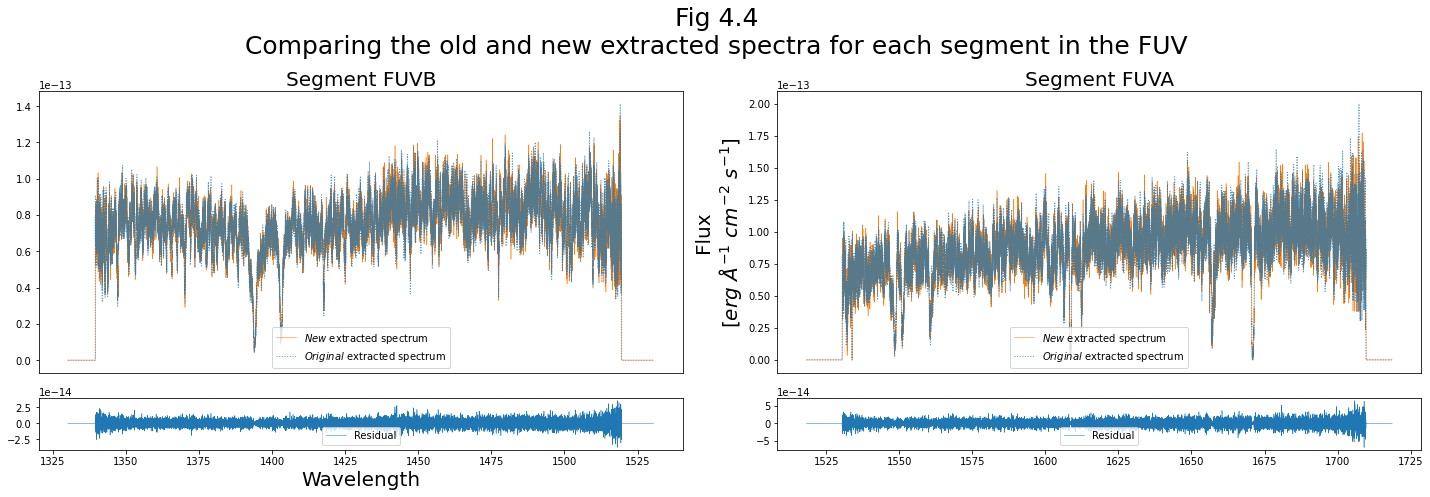

In [51]:
# Set up figure
fig = plt.figure(figsize = (20, 7))
gs = fig.add_gridspec(nrows = 5, ncols = 2) # Using gridspec to let us control panel sizes and locations

for i,j in zip([0,1],[1,0]): # use i,j to plot FUVA on the right, not the left, by inverting subplot index
    ax0 = fig.add_subplot(gs[0:4,j])
    ax1 = fig.add_subplot(gs[4:5,j])
    new_wvln, new_flux = Table.read('./output/calcos_fuv_run1/le4b01040_x1dsum.fits')[i]['WAVELENGTH', 'FLUX']
    old_wvln, old_flux, seg = Table.read(old_x1dsum)[i]['WAVELENGTH', 'FLUX', 'SEGMENT']
    
    # Interpolate the new wvln onto the old wvln's sampling:
    new_flux_interp = interp1d(x = new_wvln, y = new_flux, fill_value="extrapolate")(old_wvln)

    # give max difference:
    print(f"Stripe {seg} differs by up to: \
    {max(new_flux - old_flux)/np.mean(abs(old_flux)):.3f}%")

    # Plotting - upper panel
    ax0.plot(new_wvln,new_flux,
             alpha = 1, linewidth = .5, c = 'C1',
             label = '$New$ extracted spectrum')
    ax0.plot(old_wvln, old_flux, linewidth = 1, c = 'C0',
             linestyle = 'dotted', alpha = 0.75,
             label = '$Original$ extracted spectrum')
    # Plotting - lower panel
    ax1.plot(new_wvln,old_flux - new_flux_interp, linewidth = .5, label = 'Residual')
    # Some formatting:
    ax0.set_title(f"Segment {seg}", fontsize = 20)
    ax0.set_xticks([])
    ax0.legend(loc = 'lower center')
    ax1.legend(loc = 'lower center')
    if i == 0: # Add axis labels to the plot
        ax0.set_ylabel("Flux\n[$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", fontsize = 20)
    if i == 1:
        plt.xlabel("Wavelength", fontsize = 20)
plt.suptitle("Fig 4.4\nComparing the old and new extracted spectra for each segment in the FUV", fontsize = 25)
plt.tight_layout()
plt.savefig(plotsdir+"comp_fuv_extracted.png", dpi = 200)

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).


---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Elaine Mae Frazer

**Updated On:** 2021-03-30

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topE)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>